In [106]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import xgboost as xgb


In [107]:

generation = pd.read_csv("datasets/Generacion_fotovoltaica.csv", sep=",")

In [108]:
# Rename columns to Prophet defaults
generation.rename(columns={'FECHA': 'ds', 'TOTAL_KWH_ENERGIA': 'y'}, inplace=True)

# Convert the 'ds' column to datetime
generation['ds'] = pd.to_datetime(generation['ds'])

# Augment the dataset with year, month, day, and hour
generation['year'] = generation['ds'].dt.year
generation['month'] = generation['ds'].dt.month
generation['day'] = generation['ds'].dt.day
generation['hour'] = generation['ds'].dt.hour

# Note: Extracting the day of the week (0-6, where 0 is Monday)
generation['weekday'] = generation['ds'].dt.weekday

generation['is_weekend'] = (generation['weekday'] >= 5).astype(int)  # 1 if Sat/Sun, else 0

#Augmented dataset
generation = generation[['ds', 'year', 'month', 'day', 'weekday', 'is_weekend', 'hour', 'y']]

# Clip negative values in 'y' to 0
generation['y'] = generation['y'].clip(lower=0)


generation

,ds,year,month,day,weekday,is_weekend,hour,y
0,2023-07-24 11:00:00,2023,7,24,0,0,11,NaN
1,2023-07-24 12:00:00,2023,7,24,0,0,12,115.66
2,2023-07-24 13:00:00,2023,7,24,0,0,13,129.98
3,2023-07-24 14:00:00,2023,7,24,0,0,14,134.35
4,2023-07-24 15:00:00,2023,7,24,0,0,15,133.90
...,...,...,...,...,...,...,...,...
9703,2024-08-31 19:00:00,2024,8,31,5,1,19,NaN
9704,2024-08-31 20:00:00,2024,8,31,5,1,20,NaN
9705,2024-08-31 21:00:00,2024,8,31,5,1,21,NaN
9706,2024-08-31 22:00:00,2024,8,31,5,1,22,NaN


In [109]:
generation.shape

(9708, 8)

In [110]:
sum(generation['y'].isnull())

1164

In [111]:
# Impute null values to 0 for the specified hours
generation.loc[generation['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5, 6, 7]) & generation['y'].isnull(), 'y'] = 0

print(sum(generation['y'].isnull()))


699


In [112]:
missing_mask = generation['y'].isna()

In [113]:

# Load the dataset (assuming it's already in memory)
df = generation.copy()

# Filter for remaining NaNs after zero imputation
df_missing = df[df['y'].isna()]

In [114]:
potential_na_fix = generation[generation['y'].isna() & generation['month'].isin([10, 11, 12, 1, 2]) & generation['hour'].isin([19,20,21,8])]
len(potential_na_fix)

53

In [115]:
# Initialize the Iterative Imputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Select the columns to impute
columns_to_impute = ['y']

# Apply the imputer to the 'y' column
generation[columns_to_impute] = imputer.fit_transform(generation[columns_to_impute])

In [116]:
generation.isna().sum()

ds            0
year          0
month         0
day           0
weekday       0
is_weekend    0
hour          0
y             0
dtype: int64

In [117]:
meteo = pd.read_csv("datasets/Meteorologia.csv", sep=",")

In [118]:
meteo.shape

(100557, 27)

In [119]:
counter = 0
for i in meteo:
    if meteo[i].isnull().any():
        counter += 1

print(counter)

1


In [120]:
meteo["FORECAST_TIMESTAMP"] = pd.to_datetime(meteo["FORECAST_TIMESTAMP"])
# Convert 'ds' in generation to UTC timezone (same as 'FORECAST_TIMESTAMP' in meteo_filtered)


In [121]:
meteo_filtered = meteo.drop(columns=['LATITUDE', 'LONGITUDE'])
meteo_filtered['FORECAST_TIMESTAMP'] = meteo_filtered['FORECAST_TIMESTAMP'].dt.tz_localize(None)  # Remove timezone
generation['ds'] = generation['ds'].dt.tz_localize(None)  # Remove timezone from 'ds' if any

generation = generation.merge(meteo_filtered, left_on='ds', right_on='FORECAST_TIMESTAMP', how='left')

# Drop the 'FORECAST_TIMESTAMP' column after merging (if you don't need it)
generation.drop(columns=['FORECAST_TIMESTAMP'], inplace=True)

# Optionally, reorder the column 'y' back to its original position if needed
aux = generation['y']
generation = generation.drop(columns=['y'])
generation['y'] = aux

# Display the first few rows of the result
generation.head()

,ds,year,month,day,weekday,is_weekend,hour,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,...,tccatmosphere_0,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80,y
0,2023-07-24 11:00:00,2023,7,24,0,0,11,6.989717,1.524463,19.6,...,0.8,298.878662,301.632129,291.701489,324.006396,0.0,316.100012,7.979102,1.763457,24.085597
1,2023-07-24 11:00:00,2023,7,24,0,0,11,6.629717,1.254463,17.5,...,0.0,299.078662,301.832129,292.501489,322.706396,0.0,316.600012,7.379102,1.483457,24.085597
2,2023-07-24 11:00:00,2023,7,24,0,0,11,5.919717,1.214463,15.9,...,0.0,298.778662,301.332129,292.801489,321.706396,0.0,316.500012,6.679102,1.453457,24.085597
3,2023-07-24 11:00:00,2023,7,24,0,0,11,5.559717,3.944463,18.6,...,5.0,299.078662,301.732129,292.001489,325.806396,0.0,316.400012,6.229102,3.803457,24.085597
4,2023-07-24 11:00:00,2023,7,24,0,0,11,6.449717,3.024463,17.4,...,3.6,298.978662,301.832129,292.501489,324.806396,0.0,316.500012,7.329102,3.113457,24.085597


In [122]:
generation.shape

(87372, 32)

In [123]:
missing_columns = generation.columns[generation.isnull().any()]
print("Columns with missing values:", missing_columns)

Columns with missing values: Index(['SUNSDsurface_0'], dtype='object')


In [124]:
generation = generation.drop(columns=(missing_columns))

In [125]:
# Define the cutoff date for the train-test split
cutoff_date = '2024-07-31'
# Training data is strictly before the test period and avoids Data Leakage.
# No shuffling is done, preserving the Chronological Order.


# Split into train (before May 1st) and test (from May 1st onwards until June 1st)
train_df = generation[generation['ds'] <= cutoff_date]
test_df = generation[generation['ds'] > cutoff_date]

# Drop unnecessary columns for training
X_train = train_df.drop(columns=['ds', 'y'])
X_test = test_df.drop(columns=['ds', 'y'])
# fechaHora is the timestamp and should not be a predictor


# Ensuring y_train contain only the target variable
y_train = train_df['y']
y_test = test_df['y']

# Print dataset shapes
print(f"X_Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"y_Train shape: {y_train.shape}, Test shape: {y_test.shape}")

X_Train shape: (80469, 29), Test shape: (6903, 29)
y_Train shape: (80469,), Test shape: (6903,)


## LSTM Training

In [126]:
import torch
import torch.nn as nn
import torch.optim as optim

In [127]:
class genLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(genLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        # Define a fully connected layer to map hidden state to output
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(x.device)  # (num_layers, batch_size, hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(x.device)

        # Pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))

        # Take the output of the last time step
        out = out[:, -1, :]

        # Pass through the fully connected layer
        out = self.fc(out)
        return out

In [128]:
# Convert X_train and X_test to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Convert y_train and y_test to PyTorch tensors
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Reshape to (samples, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)    # Reshape to (samples, 1)

# Reshape X_train and X_test to 3D format (samples, timesteps, features)
# Assuming each sample has 1 timestep
X_train_tensor = X_train_tensor.view(len(X_train_tensor), 1, X_train_tensor.shape[1])
X_test_tensor = X_test_tensor.view(len(X_test_tensor), 1, X_test_tensor.shape[1])

# Print shapes to verify
print(f"X_train shape: {X_train_tensor.shape}, y_train shape: {y_train_tensor.shape}")
print(f"X_test shape: {X_test_tensor.shape}, y_test shape: {y_test_tensor.shape}")

X_train shape: torch.Size([80469, 1, 29]), y_train shape: torch.Size([80469, 1])
X_test shape: torch.Size([6903, 1, 29]), y_test shape: torch.Size([6903, 1])


In [129]:
hidden_layer_size = 50  # Arbitrary
output_size = y_train.shape[0]  # Regression problem
input_size = X_train.shape[1]  # Number of features

In [ ]:
# Define hyperparameters
num_epochs = 50
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = genLSTM(input_size=input_size, hidden_layer_size=hidden_layer_size, output_size=output_size)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Move model to the same device as the data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for every epoch
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

In [ ]:
with torch.no_grad():  # No need to compute gradients during testing
    # Assuming X_test is preprocessed the same way as X_train
    predictions = model(X_test)
    print("Predictions: ", predictions)

Predictions:  tensor([-20.7157, -20.6374, -20.5833, -20.7159, -20.3886, -20.6064, -20.4155,
        -20.4781, -20.6423, -20.5457, -20.4769, -20.6088, -20.5858, -20.6932,
        -20.4856, -20.5243, -20.6283, -20.6242, -20.2464, -20.4830, -20.4751,
        -20.4662, -20.1795, -20.6473, -20.5671, -20.6596, -20.7003, -20.4848,
        -20.5978, -20.3095, -20.3455, -20.7328, -20.5046, -20.2471, -20.6781,
        -20.6453, -20.4717, -20.5945, -20.4361, -20.3084, -20.3825, -20.4926,
        -20.4109, -20.5637, -20.3068, -20.5932, -20.7347, -20.6197, -20.0563,
        -20.3851, -20.5120, -20.4218, -20.6502, -20.6302, -20.4825, -20.5123,
        -20.5138, -20.3274, -20.5579, -20.5133, -20.2661, -20.3846, -20.5787,
        -20.7675, -20.4241, -20.3718, -20.5411, -20.4608, -20.3773, -20.5335,
        -20.6139, -20.6992, -20.6435, -20.5164, -20.4086, -20.4956, -20.6696,
        -20.5105, -20.2681, -20.9272, -20.4827, -20.2780, -20.4098, -20.6630,
        -20.5427, -20.5371, -20.4178, -20.6155, -2

In [140]:
len(predictions)

767

In [26]:
# Generate timestamps for September
future_dates = pd.date_range(start='2024-09-01 00:00:00', end='2024-09-30 23:00:00', freq='h')

# Create an empty DataFrame for predictions
future_df = pd.DataFrame({'ds': future_dates})

# Convert Timestamp Features
future_df['hour'] = future_df['ds'].dt.hour
future_df['day'] = future_df['ds'].dt.day
future_df['month'] = future_df['ds'].dt.month
future_df['weekday'] = future_df['ds'].dt.weekday
future_df['is_weekend'] = (future_df['weekday'] >= 5).astype(int)

# Apply Cyclical Encoding
future_df['hour_sin'] = np.sin(2 * np.pi * future_df['hour'] / 24)
future_df['hour_cos'] = np.cos(2 * np.pi * future_df['hour'] / 24)

future_df['day_sin'] = np.sin(2 * np.pi * future_df['day'] / 31)
future_df['day_cos'] = np.cos(2 * np.pi * future_df['day'] / 31)

future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)

last_known_data = df[df['ds'] >= '2024-08-31'].copy()


In [29]:
# Keep only the required columns for submission
submission_df = future_df[['ds', 'Energia']]

# Save as CSV
submission_filename = 'Challenge1_GroupX.csv'  # Replace 'GroupX' with your team name if needed

#print(f"✅ Submission file saved as '{submission_filename}'")

# Clip the values of 'Energia' column lower than 0.5 to 0
submission_df['Energia'] = submission_df['Energia'].apply(lambda x: 0 if x < 0.5 else x)
submission_df.to_csv(submission_filename, index=False)
submission_df.head(20)


C:\Users\juanf\AppData\Local\Temp\ipykernel_45100\1195972872.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df['Energia'] = submission_df['Energia'].apply(lambda x: 0 if x < 0.5 else x)


,ds,Energia
0,2024-09-01 00:00:00,0.000000
1,2024-09-01 01:00:00,0.000000
2,2024-09-01 02:00:00,0.000000
3,2024-09-01 03:00:00,0.000000
4,2024-09-01 04:00:00,0.000000
5,2024-09-01 05:00:00,0.000000
6,2024-09-01 06:00:00,0.000000
7,2024-09-01 07:00:00,0.000000
8,2024-09-01 08:00:00,1.152616
9,2024-09-01 09:00:00,3.624847


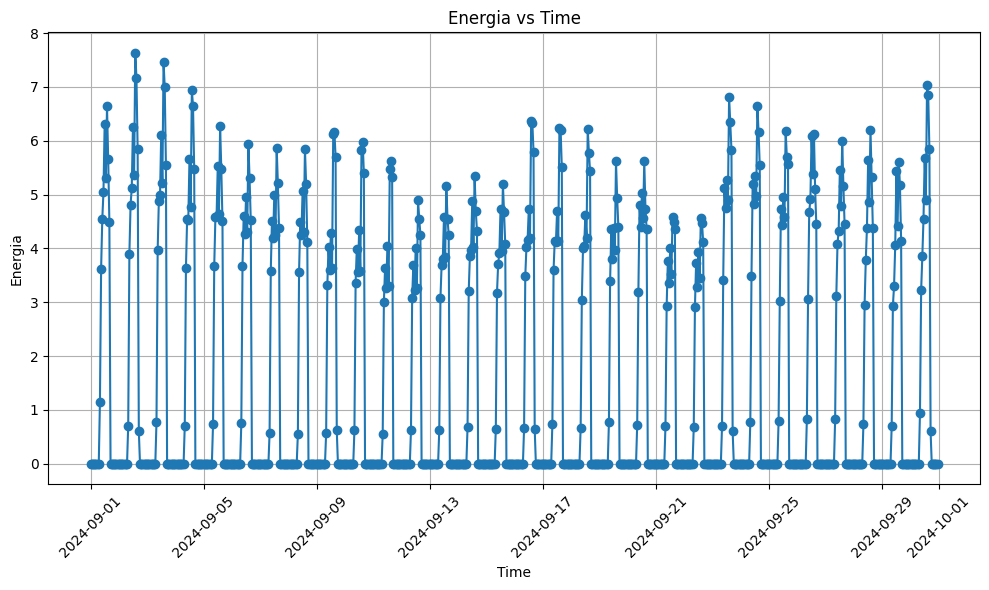

In [30]:
import matplotlib.pyplot as plt

# Plot the values of Energia against time
plt.figure(figsize=(10, 6))
plt.plot(submission_df['ds'], submission_df['Energia'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Energia')
plt.title('Energia vs Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
